# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [1]:
import os.path

In [2]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [4]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Data***

**Loading dataset**

In [5]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [6]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [7]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [8]:
final_number_of_columns = len(data.columns)

**Train and test split**

In [9]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [22]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [23]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [24]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [25]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.6
P_MUTATION = 0.2
ELITE_SIZE = round(0.01*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 320

**Creating DEAP toolbox**

In [26]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=10)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [27]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.504887	0.0288848	0.387747	0.576714	0.390466    	145            	47.425    	252       	0             	3.91618        
1  	46     	0.50721 	0.0257409	0.387747	0.565204	0.5679      	53             	47.915    	233       	0.00229502    	2.74374        
2  	20     	0.51172 	0.0276744	0.387747	0.630691	0.630699    	70             	52.865    	173       	0.00204492    	2.74255        
3  	11     	0.508422	0.0257102	0.387747	0.578409	0.630699    	70             	57.65     	169       	0.00199413    	2.75321        
4  	3      	0.510906	0.0237737	0.387747	0.578439	0.630699    	70             	58.945    	169       	0.00201488    	2.7214         
5  	4      	0.507322	0.0268293	0.387747	0.579509	0.630699    	70             	60.335    	169       	0.00196314    	2.8155         
6  	4      	0.51332 	0.0210287	0.387747	0.562349	0.630699    	70             	62.03

62 	1      	0.515914	0.0332793	0.377041	0.576297	0.639581    	111            	82.595    	154       	0.00203419    	2.50802        
63 	0      	0.516162	0.0339435	0.377041	0.576773	0.639581    	111            	78.39     	154       	0.00194693    	2.37314        
64 	1      	0.517373	0.0354579	0.377041	0.577606	0.639581    	111            	77.595    	155       	0.00196815    	2.61402        
65 	0      	0.514672	0.033246 	0.377041	0.578052	0.639581    	111            	77.44     	158       	0.00208902    	2.39128        
66 	1      	0.510956	0.0337846	0.377041	0.578052	0.639581    	111            	75.91     	151       	0.00254726    	2.15602        
67 	0      	0.515384	0.0299734	0.377041	0.578052	0.639581    	111            	74.99     	148       	0.00196195    	2.37656        
68 	1      	0.515896	0.0302322	0.377041	0.578052	0.639581    	111            	75.98     	144       	0.00195718    	2.41764        
69 	2      	0.514473	0.0290213	0.377041	0.577487	0.639581    	111            	80.50

**Statistics**

In [28]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.504887,0.028885,0.387747,0.576714,0.390466,145,47.425,252,0.000000,3.916181
1,1,46,0.507210,0.025741,0.387747,0.565204,0.567900,53,47.915,233,0.002295,2.743744
2,2,20,0.511720,0.027674,0.387747,0.630691,0.630699,70,52.865,173,0.002045,2.742554
3,3,11,0.508422,0.025710,0.387747,0.578409,0.630699,70,57.650,169,0.001994,2.753213
4,4,3,0.510906,0.023774,0.387747,0.578439,0.630699,70,58.945,169,0.002015,2.721403
5,5,4,0.507322,0.026829,0.387747,0.579509,0.630699,70,60.335,169,0.001963,2.815503
6,6,4,0.513320,0.021029,0.387747,0.562349,0.630699,70,62.030,170,0.001994,2.803679
7,7,3,0.513218,0.020596,0.387747,0.562349,0.630699,70,68.765,200,0.002238,2.767642
8,8,2,0.514141,0.022231,0.387747,0.566097,0.630699,70,68.455,190,0.001994,2.847306
9,9,0,0.510676,0.022066,0.387747,0.558216,0.630699,70,67.455,159,0.002203,2.817577


**Best individual**

In [29]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
add(x[63],sub(x[5],68.79))

Training Fitness:  0.6373531598513011

Depth:  5

Length of the genome:  111

Used portion of the genome: 0.08



Testing Best Individual

In [12]:
x = X_test

def get_confusion_matrix(Y_labels, Y_predictions):
    TP, FN, TN, FP = 0, 0, 0, 0
    for x, y in zip(Y_labels, Y_predictions):
      if x == 0:
        if y == 0:
          TN = TN + 1
        else:
          FP = FP + 1
      elif x == 1:
        if y == 1:
          TP = TP + 1
        else:
          FN = FN + 1
    return TP, FN, TN, FP

In [13]:
predictions = add(x[63],sub(x[5],68.79))
print("Predictions ", predictions)
print()

Y_prediction_class = [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]
print("Labels", Counter(Y_prediction_class))
print()

print("************ Fitness Metrics ************")
print()

TP, FN, TN, FP = get_confusion_matrix(Y_test, Y_prediction_class)
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
print("Accuracy:             ", accuracy)
print()

TPR = TP/(TP+FN)
print("True positive rate:   ", TPR)
print()

TNR = TN/(TN+FP)
print("True negative rate:   ", TNR)
print()

FPR = FP/(FP+TN)
print("False positive rate:  ", FPR)
print()

FNR = FN/(FN+TP)
print("False negative rate:  ", FNR)
print()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
print("Area under the curve: ", auc)

Predictions  [-67.38008542  24.0742717  -10.07306512 ... -11.7071736    9.23160164
   9.34389375]

Labels Counter({1: 10439, 0: 3972})

************ Fitness Metrics ************

Accuracy:              0.6451321906876691

True positive rate:    0.8695350451075642

True negative rate:    0.42076047737996114

False positive rate:   0.5792395226200389

False negative rate:   0.1304649548924358

Area under the curve:  0.6451477612437626


**Best individuals plots**

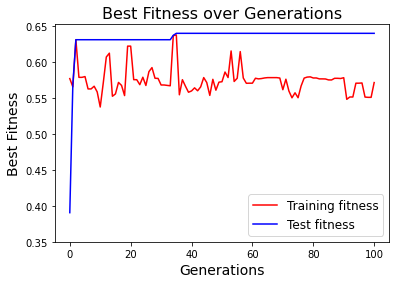

In [44]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

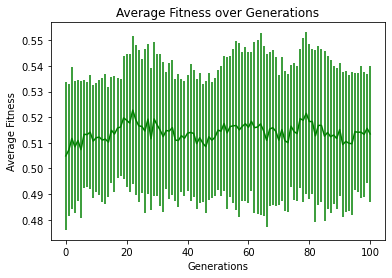

In [45]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

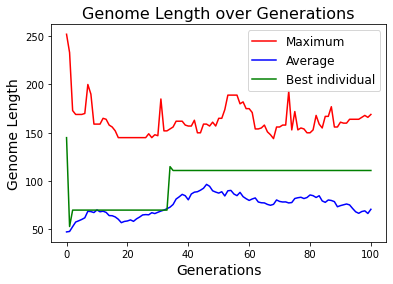

In [46]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()